In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import math
import sys

# removes futurewarnings from showing up due to errors='ignore'
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
# downloading the librairies we use 

total_ER_visits_US = pd.read_csv("US-ER-Totals.csv")

medicaid_data = pd.read_html("https://worldpopulationreview.com/state-rankings/medicaid-enrollment-by-state")[0]
# importing in data about the number of people per state enrolled in medicaid on November 1st 2022 as a dataframe

health_care_inflation_data = pd.read_html("https://www.usinflationcalculator.com/inflation/health-care-inflation-in-the-united-states/")[0]
# importing in data that shows the inflation percentage of health care costs in the US from 1948 to 2022 as a dataframe                   

health_care_inflation_data = health_care_inflation_data.apply(pd.to_numeric, axis=1, downcast='float', errors = 'ignore')
# turning the health care inflation data entries from strings to floats so mathmatocal equations can be used on the data

In [2]:


def find_health_care_costs(starting_cost, yearly_inflation: pd.DataFrame):
    """
    Takes the cost of healthcare for a previous year and multiplies it by the inflation rate of the next year to find that next year's health care costs

    Args:
        starting_cost: a float type that represents the cost of health care in the first year of the range of time
        yearly_inflation: a list of float types in a DataFrame that represent the inflation percentage of between the 
        last year and the next that is applied to the cost of health acre from previous years to generate next year's costs

    Returns:
        Returns a list of floats and/or integers that represent the cost of health care for a range of years
    """
    health_care_costs = []
    
    for item in yearly_inflation:
        percent = 1 + (item/100)
        single_year_cost = (percent * starting_cost)
        single_year_cost = round(single_year_cost)
        health_care_costs.append(single_year_cost)
        starting_cost = single_year_cost

    return health_care_costs


In [3]:
# this series takes the inflation perctanghe for each month in a row representing a year and finds the mean for that year, 
# saving the means in their own column to corresponde each mean as the inflation percnatge for that year 

display(health_care_inflation_data.head())


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1,1948.0,6.1,5.3,6.0,6.7,5.9,5.9,7.4,6.6,5.8,5.8,6.5,5.8
2,1949.0,5.7,5.7,5.0,3.5,3.5,3.5,2.1,2.8,2.8,2.1,1.4,1.4
3,1950.0,1.4,1.4,1.4,1.4,1.4,1.4,2.0,1.3,2.0,2.7,2.7,3.4
4,1951.0,3.3,3.3,4.7,4.7,5.3,5.3,4.6,5.3,4.6,4.6,5.2,5.8


In [4]:

years = health_care_inflation_data[0]
years.drop(years.index[-1], axis=0, inplace=True) # drops the last row which is empty 
years.drop(years.index[0], axis=0, inplace=True) # drops the first row which has not date, just a column title

inflation_percentage = health_care_inflation_data[1:78] # takes only the rows containing the inflation percentage to get rid of the row of month names

inflation_percentage.drop(inflation_percentage.columns[0], axis=1, inplace=True) # gets rid of the first column which contains all the years so we have only a DataFrame of inflation float values

health_care_inflation_mean = inflation_percentage.mean(axis=1) # takes the mean of each row to know the average inflation cost for each year

health_care_inflation_mean.head() # checking work

display(inflation_percentage.head()) # checking work


,1,2,3,4,5,6,7,8,9,10,11,12
1,6.1,5.3,6.0,6.7,5.9,5.9,7.4,6.6,5.8,5.8,6.5,5.8
2,5.7,5.7,5.0,3.5,3.5,3.5,2.1,2.8,2.8,2.1,1.4,1.4
3,1.4,1.4,1.4,1.4,1.4,1.4,2.0,1.3,2.0,2.7,2.7,3.4
4,3.3,3.3,4.7,4.7,5.3,5.3,4.6,5.3,4.6,4.6,5.2,5.8
5,5.8,5.8,5.1,5.1,4.4,6.3,6.3,5.7,6.3,5.6,5.0,4.3


In [5]:
# creating our first graph, the line graph

healthcare_cost_48to22 = find_health_care_costs(80.75, health_care_inflation_mean) # find our healthcare costs over time
healthcare_cost_48to22 = pd.DataFrame(healthcare_cost_48to22, columns=['Healthcare Costs That Year']) # store the final healthcare costs in a DataFrame

timeline_of_healthcare_cost = healthcare_cost_48to22.set_index(years) # make the name of the rows the years so we can call a cost from a certain year

display(timeline_of_healthcare_cost.head()) # checking work

healthcare_cost_99to22 = timeline_of_healthcare_cost[1999.0:2022.0] # isolating only the data from 1999 to 2022

display(healthcare_cost_99to22) # checking work


,Healthcare Costs That Year
0,
1948.0,86
1949.0,89
1950.0,91
1951.0,95
1952.0,100


,Healthcare Costs That Year
0,
1999.0,1508
2000.0,1569
2001.0,1641
2002.0,1718
2003.0,1787
2004.0,1866
2005.0,1945
2006.0,2023
2007.0,2112


In [ ]:
# clean up the ER data 

timeframe = total_ER_visits_US['Year']
total_ER_visits_US.drop(total_ER_visits_US.columns[0], axis=1, inplace=True) # getting rid of the 1st column that holds the years
total_ER_visits_US.set_index(timeframe, inplace=True) # renaming the rows by the year they correspond with
display(total_ER_visits_US.head())
 # checking work

,USTotal
Year,
1999,365
2000,366
2001,372
2002,382
2003,382


,Cost of E.R Visit,USTotal
1999.0,1508,365
2000.0,1569,366
2001.0,1641,372
2002.0,1718,382
2003.0,1787,382


Text(0.5, 1.0, 'Cost of an E.R. visit vs the Number of E.R vists')

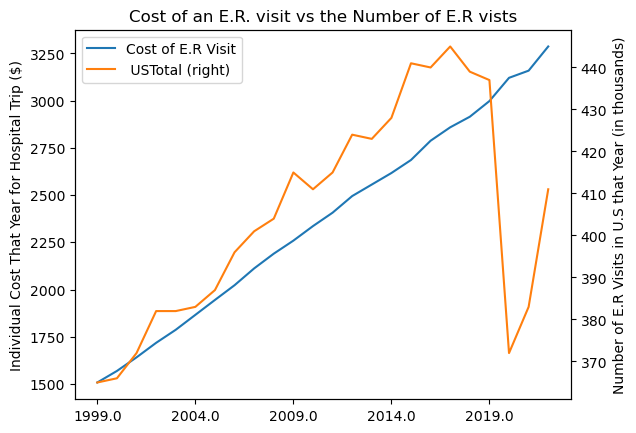

In [31]:
# combine the two dataframes into one so that they can be plotted simulationously 
combo_cost_visit_data = pd.concat([healthcare_cost_99to22, total_ER_visits_US], axis=1)
combo_cost_visit_data.rename(columns={'Healthcare Costs That Year': "Cost of E.R Visit"}, inplace=True)
combo_cost_visit_data.rename(columns={'USTotal': "Total E.R Visits"}, inplace=True)
display(combo_cost_visit_data.head())

# plot data 
combo_cost_visit_data.plot(secondary_y=combo_cost_visit_data.columns[1])
ax1, ax2 = plt.gcf().get_axes()
ax1.set_ylabel("Individual Cost That Year for Hospital Trip ($)")
ax2.set_ylabel("Number of E.R Visits in U.S that Year (in thousands)")
ax1.set_title("Cost of an E.R. visit vs the Number of E.R vists")


In [6]:
medicaid_data.head() # reviewing the format of the data 


,Unnamed: 0,State,Medicaid Enrolled↓,CHIP Enrolled,Combined Enrolled,Medicaid Plus CHIP %,State Expanded
0,NaN,California,12668401,1290747,13959148,35.19%,Yes
1,NaN,New York,6789092,557900,7346992,36.74%,Yes
2,NaN,Texas,5374020,369745,5743765,18.03%,No
3,NaN,Florida,4752201,99598,4851799,20.35%,No
4,NaN,Illinois,3504288,245958,3750246,29.35%,Yes


In [7]:

medicaid_data = medicaid_data.drop(columns=['Unnamed: 0'])
# get rid of the extra non important Unnamed: 0 column 

medicaid_data['State'] = medicaid_data['State'].replace('District of Columbia', 'D.C')
# rename Distrint of Columbia to D.C because others have said its easier to read that way

In [8]:
total_US_pop_enrolled_MedicaidCm = medicaid_data['Combined Enrolled'].sum()
# find the total number of people enrolled in the country by summing each row entry

medicaid_data["State Percentage Enrolled Out of Total US"] = ((medicaid_data['Combined Enrolled']/total_US_pop_enrolled_MedicaidCm) * 100)
# finds the percentage each state makes up of the total US medicaid enrollment

medicaid_data.head() # checking work

,State,Medicaid Enrolled↓,CHIP Enrolled,Combined Enrolled,Medicaid Plus CHIP %,State Expanded,State Percentage Enrolled Out of Total US
0,California,12668401,1290747,13959148,35.19%,Yes,15.208320
1,New York,6789092,557900,7346992,36.74%,Yes,8.004458
2,Texas,5374020,369745,5743765,18.03%,No,6.257761
3,Florida,4752201,99598,4851799,20.35%,No,5.285975
4,Illinois,3504288,245958,3750246,29.35%,Yes,4.085847


In [9]:


medicaid_data_edit = medicaid_data.copy()
other_row = {"State":"Other", 
             "Medicaid Enrolled↓": 0, 
             "CHIP Enrolled": 0, 
             "Combined Enrolled": 0, 
             "Medicaid Plus CHIP %": 0, 
             "State Expanded": "Yes", 
             "State Percentage Enrolled Out of Total US": 0}
medicaid_data_edit.loc[len(medicaid_data_edit.index)] = other_row
# creating an other column to hold the information of all states under a certain percentage threshhold 

percentage = medicaid_data['State Percentage Enrolled Out of Total US']
# creating a column of the percetnages for the whole country 

state_names = medicaid_data['State']
# creating a column of state names 

In [10]:
cycle = len(medicaid_data_edit) - 2 
other_state_perc = 0.0

while cycle > 0:
    if percentage[cycle] < 0.5:
        other_state_perc += percentage[cycle]   
        medicaid_data_edit.drop(medicaid_data_edit.index[cycle], axis=0, inplace=True)
        cycle -= 1
    else:
        cycle -= 1

# will cycle through each row of the data entry and if the percentage enrolled is less than 0.5 will add the amount to a new varible called other

In [11]:
medicaid_data_edit.loc[51, 'State Percentage Enrolled Out of Total US'] = other_state_perc
display(medicaid_data_edit.head(52))
# inserting in the new value for (other, state percentage enrolled) into the main data table

,State,Medicaid Enrolled↓,CHIP Enrolled,Combined Enrolled,Medicaid Plus CHIP %,State Expanded,State Percentage Enrolled Out of Total US
0,California,12668401,1290747,13959148,35.19%,Yes,15.208320
1,New York,6789092,557900,7346992,36.74%,Yes,8.004458
2,Texas,5374020,369745,5743765,18.03%,No,6.257761
3,Florida,4752201,99598,4851799,20.35%,No,5.285975
4,Illinois,3504288,245958,3750246,29.35%,Yes,4.085847
5,Pennsylvania,3393728,253647,3647375,27.76%,Yes,3.973770
6,Ohio,3095655,242212,3337867,27.95%,Yes,3.636565
7,Michigan,2884050,133204,3017254,29.59%,Yes,3.287261
8,Georgia,2140554,312095,2452649,21.71%,No,2.672131
9,Arizona,2140101,143032,2283133,29.68%,Yes,2.487445


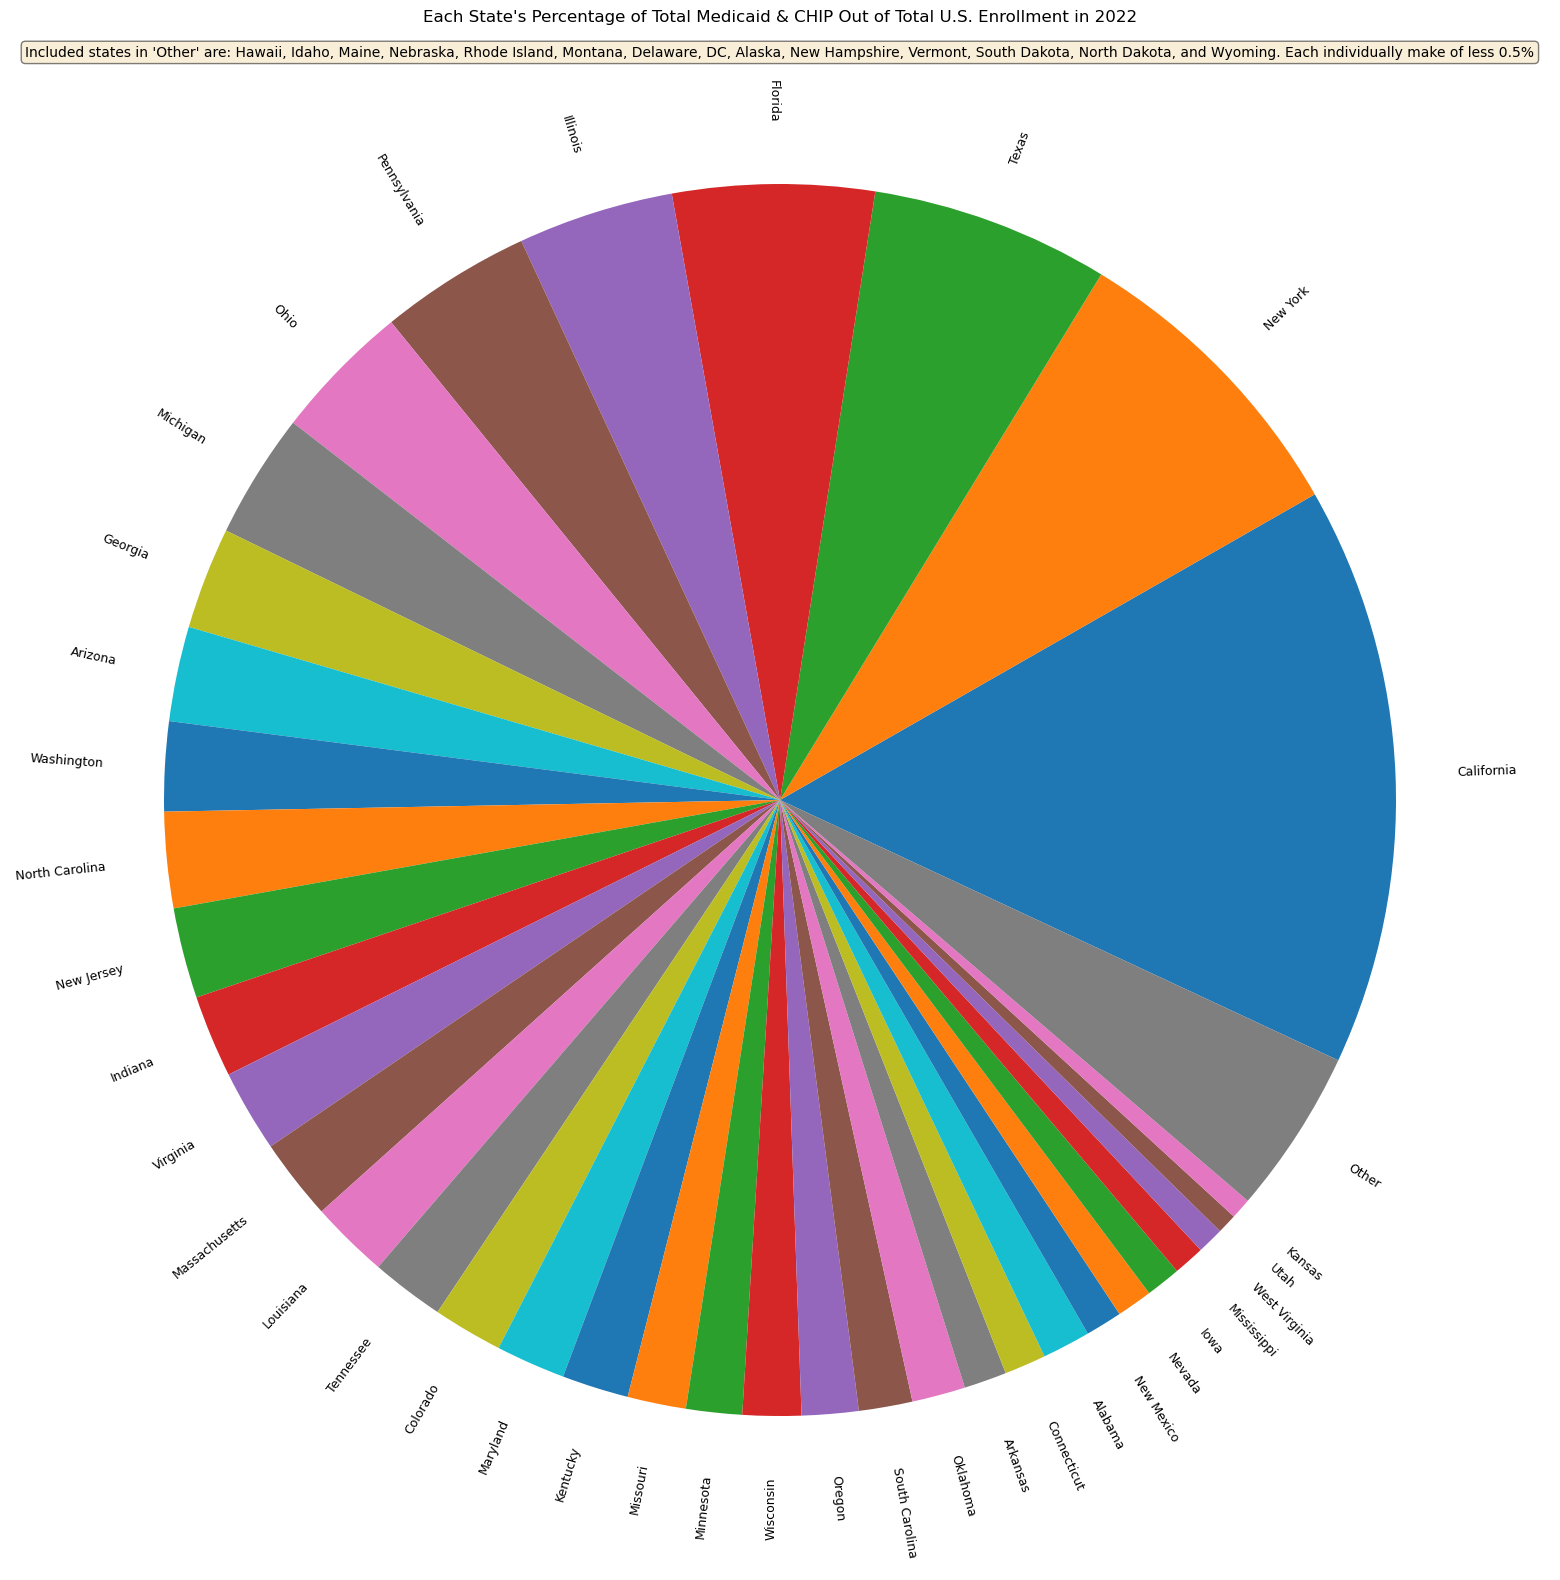

In [12]:
# plotting the pie graph

fig, ax = plt.subplots(figsize=(20,20))
l = ax.pie(medicaid_data_edit["State Percentage Enrolled Out of Total US"], startangle=-25)

for label, t in zip(medicaid_data_edit["State"], l[1]):
    x, y = t.get_position()
    angle = int(math.degrees(math.atan2(y, x)))
    ha = "left"

    if x<0:
        angle -= 180
        ha = "right"

    plt.annotate(label, xy=(x,y), rotation=angle, ha=ha, va="center", rotation_mode="anchor", size=9)
    
other_text = "Included states in 'Other' are: Hawaii, Idaho, Maine, Nebraska, Rhode Island, Montana, Delaware, " \
"DC, Alaska, New Hampshire, Vermont, South Dakota, North Dakota, and Wyoming. Each individually make of less 0.5%"

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.01, 0.99, other_text, transform=ax.transAxes, fontsize=10,
    verticalalignment='top', bbox=props)

ax.set_title("Each State's Percentage of Total Medicaid & CHIP Out of Total U.S. Enrollment in 2022")

plt.show()


In [13]:
# clean up data for bar graph
medicaid_and_CHIP_percentage = medicaid_data["Medicaid Plus CHIP %"] # isolate the column with the tptal enrollment for each state
display(medicaid_and_CHIP_percentage[0])

# for loop turns all the % strings into float values so they can be plotted
for row in range(len(medicaid_and_CHIP_percentage)):
    percent_string = medicaid_and_CHIP_percentage[row]
    
    if type(percent_string) != str:
        continue

    else:
        percent_string = percent_string.replace('%', '')
        percent_float = float(percent_string)
        medicaid_and_CHIP_percentage[row] = percent_float

medicaid_data["Medicaid Plus CHIP %"] = medicaid_and_CHIP_percentage
#type(medicaid_and_CHIP_percentage)

'35.19%'

,Combined Enrolled
State,
California,13959148
New York,7346992
Texas,5743765
Florida,4851799
Illinois,3750246


,Medicaid Plus CHIP %
State,
California,35.19
New York,36.74
Texas,18.03
Florida,20.35
Illinois,29.35


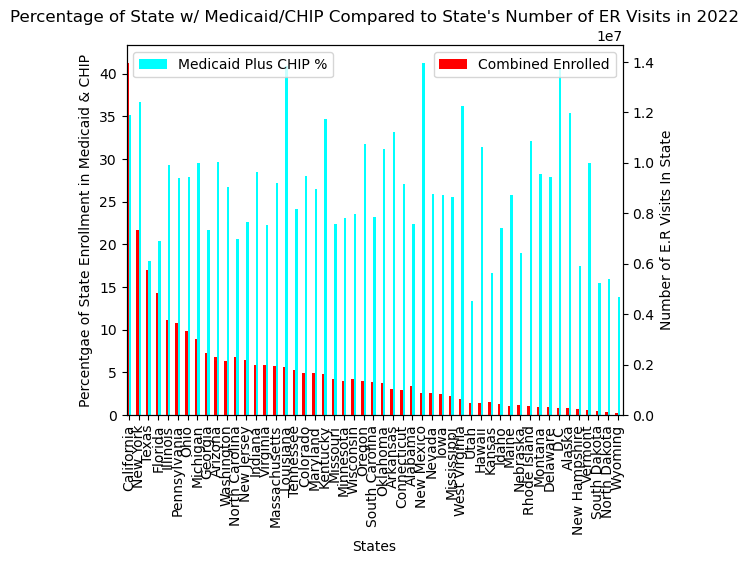

In [14]:
# plotting the bar grapg

fig = plt.figure()

ax = fig.add_subplot(111)
ax2 = ax.twinx()

width = 0.25

ER_data = pd.DataFrame(medicaid_data["Combined Enrolled"]) # change medicaid_data["Combined Enrolled"] to E.R table column 
ER_data.set_index(state_names, inplace=True) 
display(ER_data.head())
#ER_data.to_csv("ER_csv_data.csv")


medicaid_and_CHIP_percentage_data = pd.DataFrame(medicaid_data["Medicaid Plus CHIP %"])
medicaid_and_CHIP_percentage_data.set_index(state_names, inplace=True)
display(medicaid_and_CHIP_percentage_data.head())



ER_data.plot(kind='bar', color='red', ax=ax2, width=width, position=1) # test to see if code works, replace medicaid_data["Combined Enrolled"] with E.R data
medicaid_and_CHIP_percentage_data.plot(kind='bar', color='cyan', ax=ax, width=width, position=0)

ax.set_xlabel('States')
ax.set_ylabel("Percentgae of State Enrollment in Medicaid & CHIP")
ax2.set_ylabel('Number of E.R Visits In State')
ax.set_title("Percentage of State w/ Medicaid/CHIP Compared to State's Number of ER Visits in 2022")

plt.show()
